In [1]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

import sys
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from jetson.utils import cudaToNumpy, cudaMemcpy, cudaFromNumpy
from jetson_inference import poseNet
from jetson_utils import videoSource, cudaImage
import numpy as np
import os

# Load MobileNet Fine-Tuned model for drowsiness detection
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import mobilenet_v3_small
from PIL import Image

In [2]:
net = poseNet("resnet18-body", threshold=0.15)
input_source = videoSource("/dev/video0")


poseNet -- loading pose estimation model from:
        -- model        networks/Pose-ResNet18-Body/pose_resnet18_body.onnx
        -- topology     networks/Pose-ResNet18-Body/human_pose.json
        -- colors       networks/Pose-ResNet18-Body/colors.txt
        -- input_blob   'input'
        -- output_cmap  'cmap'
        -- output_paf   'paf'
        -- threshold    0.150000
        -- batch_size   1

[TRT]    topology -- keypoint 0  nose
[TRT]    topology -- keypoint 1  left_eye
[TRT]    topology -- keypoint 2  right_eye
[TRT]    topology -- keypoint 3  left_ear
[TRT]    topology -- keypoint 4  right_ear
[TRT]    topology -- keypoint 5  left_shoulder
[TRT]    topology -- keypoint 6  right_shoulder
[TRT]    topology -- keypoint 7  left_elbow
[TRT]    topology -- keypoint 8  right_elbow
[TRT]    topology -- keypoint 9  left_wrist
[TRT]    topology -- keypoint 10  right_wrist
[TRT]    topology -- keypoint 11  left_hip
[TRT]    topology -- keypoint 12  right_hip
[TRT]    topology -- ke

In [3]:
mappings = {
    0: "Nose",
    1: "Left Eye",
    2: "Right Eye",
    3: "Left Ear",
    4: "Right Ear",
    5: "Left shoulder",
    6: "Right Shoulder",
    17: "neck"
}

# Colors
keypoint_color = (50, 205, 50)  
link_color = (255, 144, 30)     
head_bbox_color = (0, 191, 255)  
eye_bbox_color = (255, 0, 255)   
label_text_color = (255, 255, 255)

filtered_keypoints_ids = set(mappings.keys())

print("PoseNet model loaded successfully!")
print("Run the next cell to start live detection with bounding boxes")

PoseNet model loaded successfully!
Run the next cell to start live detection with bounding boxes


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = mobilenet_v3_small(weights=False)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 1)
model.load_state_dict(torch.load("Models/MobileNet_224_FineTuned.pth"))
model = model.to(device)

# Convert model to half precision (FP16) for faster inference
if device.type == 'cuda':
    model = model.half()
    print("Model converted to FP16 (half precision) for optimized inference")
else:
    print("Running on CPU - keeping FP32 precision")

model.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model converted to FP16 (half precision) for optimized inference


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [5]:
eye_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_names = ['DROWSY_NOT', 'DROWSY_YES']
print("MobileNet Drowsiness Detection Model loaded successfully!")
print(f"Device: {device}")
print(f"Classes: {class_names}")

MobileNet Drowsiness Detection Model loaded successfully!
Device: cuda
Classes: ['DROWSY_NOT', 'DROWSY_YES']


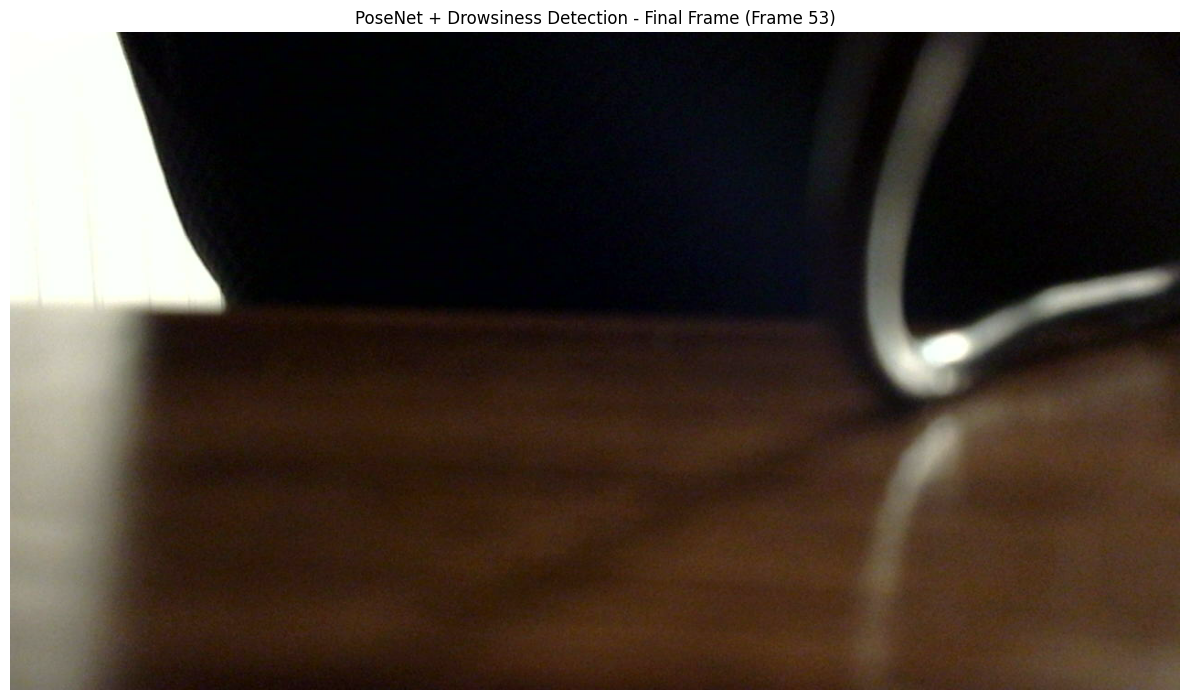


Detection stopped at frame 53
Last frame displayed above


In [6]:
try:
    frame_count = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    last_frame_rgb = None  # store the last frame to display after interruption
    
    while True:
        img = input_source.Capture()
        
        if img is None:
            print("Failed to capture frame")
            continue
        
        # Copy to CPU for OpenCV processing
        raw_img = cudaImage(width=img.width, height=img.height, format=img.format)
        cudaMemcpy(raw_img, img)
        frame = cudaToNumpy(raw_img)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
        
        poses = net.Process(img, overlay='none')
        
        for obj_idx, pose in enumerate(poses):
            keypoint_dict = {}
            
            for kp in pose.Keypoints:
                kp_id = int(kp.ID)
                if kp_id in filtered_keypoints_ids:
                    keypoint_dict[kp_id] = (int(kp.x), int(kp.y))
            
            # get key points for eyes
            left_eye = keypoint_dict.get(1)
            right_eye = keypoint_dict.get(2)
            
            # draw eye bounding box if both eyes are detected
            if left_eye is not None and right_eye is not None:
                eye_x_coords = [left_eye[0], right_eye[0]]
                eye_y_coords = [left_eye[1], right_eye[1]]
                
                eye_min_x = min(eye_x_coords)
                eye_max_x = max(eye_x_coords)
                eye_min_y = min(eye_y_coords)
                eye_max_y = max(eye_y_coords)
                
                # add padding around eyes
                eye_width = eye_max_x - eye_min_x
                eye_height = eye_max_y - eye_min_y
                
                # making the box wider and taller to cover both eyes comfortably inside the box
                eye_padding_x = int(eye_width * 0.5)
                eye_padding_y = int(max(eye_height * 2.0, eye_width * 0.4))  # just making sure it tall enough
                
                eye_bbox_x1 = max(0, eye_min_x - eye_padding_x)
                eye_bbox_y1 = max(0, eye_min_y - eye_padding_y)
                eye_bbox_x2 = min(frame.shape[1], eye_max_x + eye_padding_x)
                eye_bbox_y2 = min(frame.shape[0], eye_max_y + eye_padding_y)
                
                # Extract eye region for drowsiness detection
                eye_region = frame[eye_bbox_y1:eye_bbox_y2, eye_bbox_x1:eye_bbox_x2]
                
                # Perform drowsiness detection if eye region is valid
                drowsy_label = "Unknown"
                drowsy_prob = 0.0
                if eye_region.shape[0] > 0 and eye_region.shape[1] > 0:
                    try:
                        # Convert BGR to RGB for PIL
                        eye_region_rgb = cv2.cvtColor(eye_region, cv2.COLOR_BGR2RGB)
                        eye_pil = Image.fromarray(eye_region_rgb)
                        
                        # Apply transforms
                        eye_tensor = eye_transform(eye_pil).unsqueeze(0).to(device)
                        
                        # Convert to half precision if model is in half precision
                        if device.type == 'cuda':
                            eye_tensor = eye_tensor.half()
                        
                        # Predict
                        with torch.no_grad():
                            output = model(eye_tensor)
                            prob = torch.sigmoid(output).item()
                            pred_class = int(prob > 0.5)
                            drowsy_label = class_names[pred_class]
                            drowsy_prob = prob if pred_class == 1 else (1 - prob)
                    except Exception as e:
                        print(f"Error in drowsiness detection: {e}")
                
                # Set color based on drowsiness state
                if drowsy_label == "DROWSY_YES":
                    bbox_color = (0, 0, 255)  # Red for drowsy
                    label_bg_color = (0, 0, 255)
                elif drowsy_label == "DROWSY_NOT":
                    bbox_color = (0, 255, 0)  # Green for alert
                    label_bg_color = (0, 255, 0)
                else:
                    bbox_color = eye_bbox_color  # Magenta for unknown
                    label_bg_color = eye_bbox_color
                
                # Draw bounding box with color based on drowsiness state
                cv2.rectangle(frame, (eye_bbox_x1, eye_bbox_y1), (eye_bbox_x2, eye_bbox_y2), bbox_color, 2)
                
                # Prepare label with drowsiness info
                eye_label = f"{drowsy_label} ({drowsy_prob*100:.1f}%)"
                eye_font_scale = 0.6
                (eye_text_w, eye_text_h), _ = cv2.getTextSize(eye_label, font, eye_font_scale, 2)
                
                eye_label_x = eye_bbox_x1
                eye_label_y = max(eye_bbox_y1 - 8, 15)
                
                # Draw label background and text
                cv2.rectangle(frame, (eye_label_x, eye_label_y - eye_text_h - 6), 
                             (eye_label_x + eye_text_w + 8, eye_label_y + 2), label_bg_color, -1)
                cv2.putText(frame, eye_label, (eye_label_x + 4, eye_label_y - 2), 
                           font, eye_font_scale, label_text_color, 2, cv2.LINE_AA)
            
            # draw skeleton links
            try:
                for link in pose.Links:
                    if isinstance(link, tuple) and len(link) == 2:
                        start_id, end_id = link
                    else:
                        continue
                    
                    if start_id in keypoint_dict and end_id in keypoint_dict:
                        start_point = keypoint_dict[start_id]
                        end_point = keypoint_dict[end_id]
                        cv2.line(frame, start_point, end_point, link_color, 2)
            except:
                pass
            
            # draw keypoints
            for kp_id, (x, y) in keypoint_dict.items():
                cv2.circle(frame, (x, y), 6, (255, 255, 255), -1)
                cv2.circle(frame, (x, y), 4, keypoint_color, -1)
        
        frame_count += 1
        
        # Convert to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        last_frame_rgb = frame_rgb  
        
        clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f'PoseNet + Drowsiness Detection - Frame {frame_count}')
        plt.tight_layout()
        plt.show()
        
except KeyboardInterrupt:
    print("\nPoseNet detection stopped by user")
finally:
    if last_frame_rgb is not None:
        clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.imshow(last_frame_rgb)
        plt.axis('off')
        plt.title(f'PoseNet + Drowsiness Detection - Final Frame (Frame {frame_count})')
        plt.tight_layout()
        plt.show()
        print(f"\nDetection stopped at frame {frame_count}")
        print("Last frame displayed above")
    else:
        print("No frames were captured")
    
    plt.close('all')